## Group 19
### HA2 - Mining frequent itemsets

Cátia Antunes (60494) -<br>Donato Aveiro (46269) - 15h<br>Márcia Vital (59488) - 15h<br>Sean Gorman (59492) -

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules, fpmax
from mlxtend.preprocessing import TransactionEncoder
from PD_freqitems import freqitemsets
from pyfim import pyeclat

### Data preprocessing

In [2]:
#Read product names and IDs
lines=open("products.txt", "rt", encoding="utf8").readlines()
prod_dict={}
products=[0]*len(lines)
for lin in lines[1:]:
    pid, pname, aid, did=lin.strip().split("\t")    
    products[int(pid)]=pname
    prod_dict[pid] = pname

del products[0] #the products list contains a 0 as the first element
#products

In [3]:
#read transactions
orders=pickle.load(open("order_products.pickle", "rb"))

In [4]:
#check products on order 2:
#for prod in orders[2]: print(products[prod])

In [4]:
# Convert the transaction data into a list of lists
orders_list = [list(order) for order in orders.values()]
#orders_list

In [5]:
# Encode the transaction data as a binary matrix
te = TransactionEncoder()
te_ary = te.fit_transform(orders_list, sparse=True)

df = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)
#df

In [6]:
df.columns = [prod_dict[str(key)] for key in df.columns]
#df

### Objective 1 - Analyze the itemset/rules generation procedure

In [13]:
D={"threshold": [0.2, 0.1, 0.05, 0.02, 0.01], 
   "num_itemsets":[],
   "apriori":[], 
   "FP-growth":[], 
   "ECLAT":[], 
   "PD":[]}

for min_supp in D["threshold"]:
    t0 = time.time()
    FI_apriori=apriori(df, min_supp)
    t1 = time.time()
    D["num_itemsets"].append(FI_apriori.shape[0])
    D["apriori"].append(t1-t0)

    FI_fpg= fpgrowth(df, min_supp)
    t2 = time.time()
    D["FP-growth"].append(t2-t1)

    FI_eclat= pyeclat(orders_list, min_supp)    
    t3 = time.time()
    D["ECLAT"].append(t3-t2)

    FI_pdfis= freqitemsets(orders_list, min_supp)    
    t4 = time.time()
    D["PD"].append(t4-t3)

    
    print(min_supp, FI_apriori.shape[0],"\n\tApriori time:", t1-t0, 
          "\n\tFP-growth time:",t2-t1,
          "\n\tECLAT time:", t3-t2,
          "\n\tPD time:", t4-t3)
    

df_performance=pd.DataFrame(D)
df_performance

0.2 0 
	Apriori time: 6.3965675830841064 
	FP-growth time: 15.70045804977417 
	ECLAT time: 128.55163478851318 
	PD time: 59.036895990371704
0.1 2 
	Apriori time: 5.572005033493042 
	FP-growth time: 17.515021324157715 
	ECLAT time: 91.92771744728088 
	PD time: 59.23741841316223
0.05 6 
	Apriori time: 6.754559755325317 
	FP-growth time: 18.09499740600586 
	ECLAT time: 147.3803403377533 
	PD time: 39.31001329421997
0.02 39 
	Apriori time: 36.78520894050598 
	FP-growth time: 21.018460512161255 
	ECLAT time: 108.9571442604065 
	PD time: 39.92421579360962


C:\Users\dgonc\anaconda3\lib\site-packages\scipy\sparse\compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other
C:\Users\dgonc\anaconda3\lib\site-packages\scipy\sparse\compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other
C:\Users\dgonc\anaconda3\lib\site-packages\scipy\sparse\compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other
C:\Users\dgonc\anaconda3\lib\site-packages\scipy\sparse\compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other


0.01 102 
	Apriori time: 248.26823377609253 
	FP-growth time: 50.2638578414917 
	ECLAT time: 96.81559300422668 
	PD time: 68.22693014144897


,threshold,num_itemsets,apriori,FP-growth,ECLAT,PD
0,0.20,0,6.396568,15.700458,128.551635,59.036896
1,0.10,2,5.572005,17.515021,91.927717,59.237418
2,0.05,6,6.754560,18.094997,147.380340,39.310013
3,0.02,39,36.785209,21.018461,108.957144,39.924216
4,0.01,102,248.268234,50.263858,96.815593,68.226930


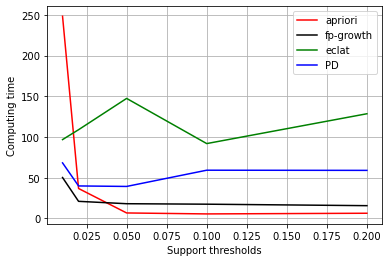

In [72]:
plt.plot(df_performance["threshold"], df_performance["apriori"], c='r', label='apriori')
plt.plot(df_performance["threshold"], df_performance["FP-growth"], c='k', label='fp-growth')
plt.plot(df_performance["threshold"], df_performance["ECLAT"], c='g', label='eclat')
plt.plot(df_performance["threshold"], df_performance["PD"], c='b', label='PD')
plt.xlabel("Support thresholds")
plt.ylabel("Computing time")
plt.grid()
plt.legend()
plt.show()

Although the apriori algorithm has the best performance for higher support thresholds, it is quickly outperformed by all the other algorithms for lower support thresholds. FP-growth and PD appear to behave relatively similar performance-wise, with the former having an advantage over PD. Thus, from now on we will be using FP-growth.

ECLAT did not have a good performance, which is surprising, since this algorithm supposedly scales well for large datasets.

### Objective 2 - Identify the most relevant rules


Let's now generate the itemsets with support = 0.02 and support = 0.01 and compare them:

In [12]:
def get_itemsets_counts(binary_df, support_list):
    for support in support_list:
        support_df = fpgrowth(binary_df, min_support=support,use_colnames=True)
        support_df['length'] = support_df['itemsets'].apply(lambda x: len(x))
        itemsets_count = list(support_df['length'].value_counts())
        print('\nWith a minimum support of {} we can get the following itemsets of n size:'.format(support))
        for i in range(1, len(itemsets_count)+1):
            print('{} different {}-itemsets'.format(itemsets_count[i-1], i))

In [13]:
get_itemsets_counts(df, [0.02, 0.01])


With a minimum support of 0.02 we can get the following itemsets of n size:
39 different 1-itemsets

With a minimum support of 0.01 we can get the following itemsets of n size:
102 different 1-itemsets
14 different 2-itemsets


There are no 2-itemsets for FP-growth when support = 0.02, in contrast to when support = 0.01. Therefore, we will continue our analysis with support = 0.01, otherwise we will not be able to generate association rules.

In [11]:
FI_fpgrowth = fpgrowth(df, min_support=0.01, use_colnames=True)
FI_fpgrowth['length'] = FI_fpgrowth['itemsets'].apply(lambda x: len(x))
FI_fpgrowth.sort_values(by=['length'], ascending=False)
FI_fpgrowth[FI_fpgrowth['length'] == 2]

,support,itemsets,length
102,0.015987,"(Banana, Organic Baby Spinach)",2
103,0.011862,"(Organic Strawberries, Organic Baby Spinach)",2
104,0.015668,"(Organic Baby Spinach, Bag of Organic Bananas)",2
105,0.019391,"(Bag of Organic Bananas, Organic Hass Avocado)",2
106,0.010856,"(Organic Baby Spinach, Organic Hass Avocado)",2
107,0.012689,"(Organic Strawberries, Organic Hass Avocado)",2
108,0.012599,"(Organic Raspberries, Bag of Organic Bananas)",2
109,0.010533,"(Organic Strawberries, Organic Raspberries)",2
110,0.017468,"(Organic Strawberries, Banana)",2
111,0.019170,"(Organic Strawberries, Bag of Organic Bananas)",2


Of the total 116 itemsets generated by FP-growth, 14 are 2-itemsets. At a first glance, they seem to make sense - different kinds of fruits are frequently bought together in real life, as well as fruits and vegetables.

Let's check all the rules and choose a set that seems relevant:

In [49]:
all_rules = association_rules(FI_fpgrowth, metric="support", min_threshold=0.01)
all_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Banana),(Organic Baby Spinach),0.146993,0.075251,0.015987,0.108758,1.445272,0.004925,1.037596,0.361180
1,(Organic Baby Spinach),(Banana),0.075251,0.146993,0.015987,0.212445,1.445272,0.004925,1.083108,0.333159
2,(Organic Baby Spinach),(Organic Strawberries),0.075251,0.082331,0.011862,0.157630,1.914594,0.005666,1.089390,0.516568
3,(Organic Strawberries),(Organic Baby Spinach),0.082331,0.075251,0.011862,0.144074,1.914594,0.005666,1.080408,0.520554
4,(Organic Baby Spinach),(Bag of Organic Bananas),0.075251,0.118030,0.015668,0.208217,1.764107,0.006787,1.113904,0.468388
5,(Bag of Organic Bananas),(Organic Baby Spinach),0.118030,0.075251,0.015668,0.132750,1.764107,0.006787,1.066301,0.491106
6,(Bag of Organic Bananas),(Organic Hass Avocado),0.118030,0.066436,0.019391,0.164293,2.472945,0.011550,1.117095,0.675333
7,(Organic Hass Avocado),(Bag of Organic Bananas),0.066436,0.118030,0.019391,0.291880,2.472945,0.011550,1.245511,0.638011
8,(Organic Baby Spinach),(Organic Hass Avocado),0.075251,0.066436,0.010856,0.144266,2.171499,0.005857,1.090951,0.583389
9,(Organic Hass Avocado),(Organic Baby Spinach),0.066436,0.075251,0.010856,0.163406,2.171499,0.005857,1.105375,0.577881


The conviction values do not seem to change much from rule to rule, with the majority having a value less than 1.2 and all having a value greater than 1, which indicates that the presence of the antecedent has a positive effect on the occurence of the consequent for all rules. As such, we will not focus too much on this metric. Likewise, as defined in Objective 1, the support values are all between 0.01 and 0.02, which means that this metric will not be as appropriate to compare rules as lift and confidence, as we know that for every rule the antecedent and the consequent appear together in 1% of all transactions.

There seems to be a greater range of values for the lift metric, with some rules having a lift value that is twice the value of others. Let's check the ones with lift >= 2.5.

In [50]:
all_rules = association_rules(FI_fpgrowth, metric="lift", min_threshold=2.5)
all_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Bag of Organic Bananas),(Organic Raspberries),0.118030,0.042632,0.012599,0.106741,2.503775,0.007567,1.071770,0.680979
1,(Organic Raspberries),(Bag of Organic Bananas),0.042632,0.118030,0.012599,0.295519,2.503775,0.007567,1.251944,0.627348
2,(Organic Strawberries),(Organic Raspberries),0.082331,0.042632,0.010533,0.127938,3.000973,0.007023,1.097821,0.726596
3,(Organic Raspberries),(Organic Strawberries),0.042632,0.082331,0.010533,0.247072,3.000973,0.007023,1.218801,0.696467
4,(Organic Fuji Apple),(Banana),0.027880,0.146993,0.010558,0.378693,2.576259,0.006460,1.372923,0.629388
5,(Banana),(Organic Fuji Apple),0.146993,0.027880,0.010558,0.071827,2.576259,0.006460,1.047348,0.717275


Of these rules with a large lift value, three seem the most relevant as they have a much greater confidence compared to the other ones. These are: 

(Organic Raspberries) => (Bag of Organic Bananas) (confidence = 0.30, lift = 2.50; row 1)

(Organic Raspberries) => (Organic Strawberries) (confidence = 0.25, lift = 3.00; row 3)

(Organic Fuji Apple) => (Banana) (confidence = 0.38, lift = 2.58; row 4)

For example, for this last rule, we can say that 38% of the transactions that contain Organic Fuji Apple also contain Banana, and the probability of Banana being purchased when Organic Fuji Apple is purchased is 2.58 times higher than the probability of Banana being purchased in general. There is a non-random relationship between these two products.

The same logic can be applied to the other rules.

Now, let's identify the maximal itemsets for 2-itemsets with support = 0.01:

In [7]:
FI_fpmax = fpmax(df, min_support=0.01, use_colnames=True)
FI_fpmax['length'] = FI_fpmax['itemsets'].apply(lambda x: len(x))
FI_fpmax.sort_values(by=['length'], ascending=False)
FI_fpmax[FI_fpmax['length'] >= 2]

,support,itemsets,length
85,0.010558,"(Organic Fuji Apple, Banana)",2
91,0.010533,"(Organic Raspberries, Organic Strawberries)",2
92,0.012599,"(Organic Raspberries, Bag of Organic Bananas)",2
95,0.012825,"(Strawberries, Banana)",2
96,0.012716,"(Large Lemon, Banana)",2
97,0.016609,"(Organic Avocado, Banana)",2
98,0.010856,"(Organic Baby Spinach, Organic Hass Avocado)",2
99,0.012689,"(Organic Strawberries, Organic Hass Avocado)",2
100,0.019391,"(Bag of Organic Bananas, Organic Hass Avocado)",2
101,0.011862,"(Organic Baby Spinach, Organic Strawberries)",2


## to finish

#### Identify the Maximal and Closed Itemsets for the same level of support (maximal is done)
#### [challenging] Generate the most relevant rules for closed and maximal itemsets with adequate statistics (support, confidence, lift and conviction) and discuss your findings

In [16]:
frequent = fpgrowth(df, min_support=0.01, use_colnames=True)
su = frequent.support.unique()#all unique support count

#Dictionary storing itemset with same support count key
fredic = {}
for i in range(len(su)):
    inset = list(frequent.loc[frequent.support ==su[i]]['itemsets'])
    fredic[su[i]] = inset

#Dictionary storing itemset with support count <= key
fredic2 = {}
for i in range(len(su)):
    inset2 = list(frequent.loc[frequent.support<=su[i]]['itemsets'])
    fredic2[su[i]] = inset2

# Find Closed frequent itemset with length >= 2
closed_itemsets = []
for index, row in frequent.iterrows():
    isclose = True
    cli = row['itemsets']
    cls = row['support']
    checkset = fredic[cls]
    
    # Only include closed frequent itemsets with length >= 2
    if len(cli) < 2:
        continue
    
    for i in checkset:
        if (cli!=i):
            if(frozenset.issubset(cli,i)):
                isclose = False
                break
    
    if(isclose):
        closed_itemsets.append({'support': cls, 'itemsets': cli})

# Create dataframe with closed frequent itemsets and length column
closed_itemsets_df = pd.DataFrame(closed_itemsets)
closed_itemsets_df['length'] = closed_itemsets_df['itemsets'].apply(lambda x: len(x))
closed_itemsets_df



,support,itemsets,length
0,0.015987,"(Organic Baby Spinach, Banana)",2
1,0.011862,"(Organic Baby Spinach, Organic Strawberries)",2
2,0.015668,"(Bag of Organic Bananas, Organic Baby Spinach)",2
3,0.019391,"(Bag of Organic Bananas, Organic Hass Avocado)",2
4,0.010856,"(Organic Baby Spinach, Organic Hass Avocado)",2
5,0.012689,"(Organic Strawberries, Organic Hass Avocado)",2
6,0.012599,"(Organic Raspberries, Bag of Organic Bananas)",2
7,0.010533,"(Organic Raspberries, Organic Strawberries)",2
8,0.017468,"(Organic Strawberries, Banana)",2
9,0.019170,"(Bag of Organic Bananas, Organic Strawberries)",2


In [17]:
# Find Max frequent itemset
min_len = 2
ml = []
for index, row in frequent.iterrows():
    isclose = True
    cli = row['itemsets']
    if len(cli) < min_len:
        continue
    cls = row['support']
    checkset = fredic2[cls]
    for i in checkset:
        if (cli!=i):
            if(frozenset.issubset(cli,i)):
                isclose = False
                break
    
    if(isclose):
        ml.append([cls, cli])

ml_df = pd.DataFrame(ml, columns=['support', 'itemsets'])
ml_df['length'] = ml_df['itemsets'].apply(lambda x: len(x))
ml_df



,support,itemsets,length
0,0.015987,"(Organic Baby Spinach, Banana)",2
1,0.011862,"(Organic Baby Spinach, Organic Strawberries)",2
2,0.015668,"(Bag of Organic Bananas, Organic Baby Spinach)",2
3,0.019391,"(Bag of Organic Bananas, Organic Hass Avocado)",2
4,0.010856,"(Organic Baby Spinach, Organic Hass Avocado)",2
5,0.012689,"(Organic Strawberries, Organic Hass Avocado)",2
6,0.012599,"(Organic Raspberries, Bag of Organic Bananas)",2
7,0.010533,"(Organic Raspberries, Organic Strawberries)",2
8,0.017468,"(Organic Strawberries, Banana)",2
9,0.019170,"(Bag of Organic Bananas, Organic Strawberries)",2


In [18]:
print(len(FI_fpmax) == len(ml_df))

print(FI_fpmax['support'].tolist() == ml_df['support'].tolist())
print(FI_fpmax['itemsets'].tolist() == ml_df['itemsets'].tolist())

False
False
False


In [11]:
print(set(ml_df['itemsets']) == set(FI_fpmax['itemsets']))
print(set(ml_df['support']) == set(FI_fpmax['support']))

False
False


In [19]:
#Join the two dataframes
merged_df = FI_fpmax.merge(ml_df, on='itemsets', how='outer', suffixes=('_max', '_ml'))

#Identify the rows that appear in binary_database_max and not in ml_df
only_max_df = merged_df[merged_df['support_ml'].isna()][['support_max', 'itemsets']]
only_max_df = only_max_df.rename(columns={'support_max': 'support'})

#Identify the rows that appear in ml_df and not in binary_database_max
only_ml_df = merged_df[merged_df['support_max'].isna()][['support_ml', 'itemsets']]
only_ml_df = only_ml_df.rename(columns={'support_ml': 'support'})

#Identify the rows that appear in both dataframes
common_df = merged_df.dropna()[['support_max', 'itemsets']]
common_df = common_df.rename(columns={'support_max': 'support'})

print("Unique rows in binary_database_max:")
print(only_max_df)

print("\nUnique rows in ml_df:")
print(only_ml_df)

print("\nCommon rows:")
print(common_df)

Unique rows in binary_database_max:
     support                    itemsets
0   0.010063      (Feta Cheese Crumbles)
1   0.010120     (Organic Russet Potato)
2   0.010199     (Sparkling Lemon Water)
3   0.010230  (Organic Broccoli Florets)
4   0.010547         (Pure Irish Butter)
..       ...                         ...
88  0.032606          (Organic Zucchini)
89  0.034147            (Organic Garlic)
90  0.035282      (Organic Yellow Onion)
93  0.042896        (Organic Whole Milk)
94  0.043743                     (Limes)

[92 rows x 2 columns]

Unique rows in ml_df:
Empty DataFrame
Columns: [support, itemsets]
Index: []

Common rows:
      support                                        itemsets
85   0.010558                    (Organic Fuji Apple, Banana)
91   0.010533     (Organic Raspberries, Organic Strawberries)
92   0.012599   (Organic Raspberries, Bag of Organic Bananas)
95   0.012825                          (Strawberries, Banana)
96   0.012716                           (Large 